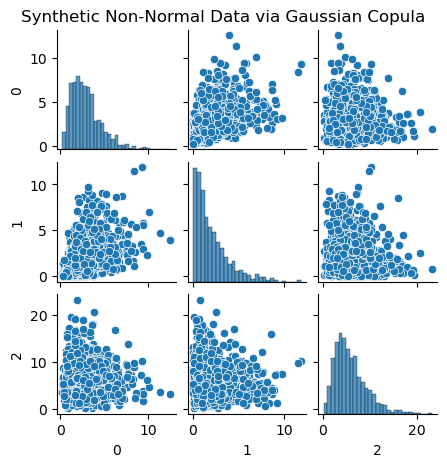

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha_gamma]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [rate_exp]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [nu_chi2]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sam

/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 33 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


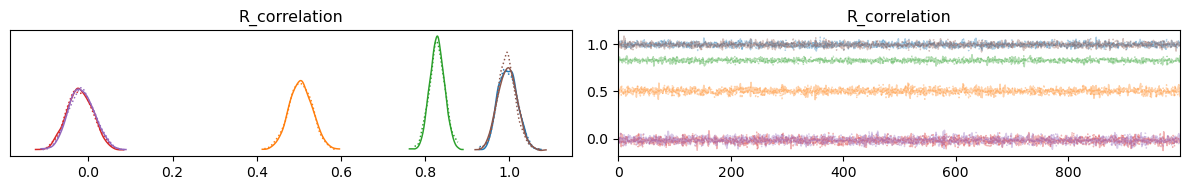

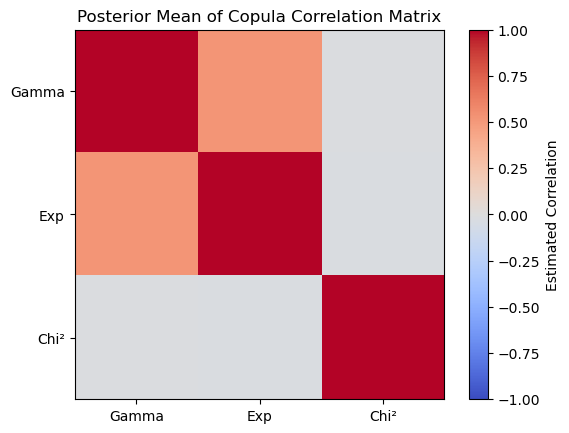

True

In [10]:
#Q1
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats

# Step 1: Simulate data using Gaussian copula with standard normal
N = 1000
rho = 0.5
cov = [
    [1.0, rho, 0.0],
    [rho, 1.0, 0.0],
    [0.0, 0.0, 1.0]
]
x = np.random.multivariate_normal(mean=[0, 0, 0], cov=cov, size=N)

# Step 2: Transform to non-Gaussian marginals via PPF
y = x.copy()
y[:, 0] = stats.gamma(a=3).ppf(stats.norm().cdf(x[:, 0]))        # Gamma
y[:, 1] = stats.expon(scale=2).ppf(stats.norm().cdf(x[:, 1]))    # Exponential
y[:, 2] = stats.chi2(df=6).ppf(stats.norm().cdf(x[:, 2]))        # Chi²

# Visualize transformed data
sns.pairplot(pd.DataFrame(y), height=1.5)
plt.suptitle("Synthetic Non-Normal Data via Gaussian Copula", y=1.02)
plt.show()

# Step 3: Fit marginals separately with PyMC
with pm.Model() as marginal_gamma:
    alpha_gamma = pm.HalfNormal("alpha_gamma", sigma=10)
    obs_gamma = pm.Gamma("obs_gamma", alpha=alpha_gamma, beta=1.0, observed=y[:, 0])
    trace_gamma = pm.sample(1000, tune=1000, cores=1, progressbar=False, random_seed=42)

with pm.Model() as marginal_expon:
    rate_exp = pm.HalfNormal("rate_exp", sigma=10)
    obs_expon = pm.Exponential("obs_expon", lam=rate_exp, observed=y[:, 1])
    trace_expon = pm.sample(1000, tune=1000, cores=1, progressbar=False, random_seed=42)

with pm.Model() as marginal_chi2:
    nu_chi2 = pm.HalfNormal("nu_chi2", sigma=10)
    obs_chi2 = pm.ChiSquared("obs_chi2", nu=nu_chi2, observed=y[:, 2])
    trace_chi2 = pm.sample(1000, tune=1000, cores=1, progressbar=False, random_seed=42)

# Step 4: Extract posterior means for transformation
alpha_gamma_mean = az.summary(trace_gamma, var_names=["alpha_gamma"])["mean"].values[0]
rate_exp_mean    = az.summary(trace_expon, var_names=["rate_exp"])["mean"].values[0]
nu_chi2_mean     = az.summary(trace_chi2, var_names=["nu_chi2"])["mean"].values[0]

# Step 5: Transform marginals to standard normal space
cdf_gamma = stats.gamma(a=alpha_gamma_mean, scale=1).cdf(y[:, 0])
z0 = stats.norm.ppf(cdf_gamma)

cdf_expon = stats.expon(scale=1.0 / rate_exp_mean).cdf(y[:, 1])
z1 = stats.norm.ppf(cdf_expon)

cdf_chi2 = stats.chi2(df=nu_chi2_mean).cdf(y[:, 2])
z2 = stats.norm.ppf(cdf_chi2)

Z = np.column_stack([z0, z1, z2])

# Step 6: Gaussian copula modeling with PyMC
with pm.Model() as copula_model:
    L_chol, Rho, _ = pm.LKJCholeskyCov(
        "R_correlation", n=3, eta=2.0,
        sd_dist=pm.Exponential.dist(1.0, shape=3),
        compute_corr=True
    )
    pm.Deterministic("R", Rho)
    pm.MvNormal("Z_likelihood", mu=np.zeros(3), chol=L_chol, observed=Z)
    trace_copula = pm.sample(1000, tune=1000, cores=1, progressbar=True, random_seed=42)

# Step 7: Posterior diagnostics
az.plot_trace(trace_copula, var_names=["R_correlation"])
plt.tight_layout()
plt.show()

# Step 8: Posterior correlation matrix mean
mean_corr = trace_copula.posterior["R"].mean(dim=["chain", "draw"]).values
mean_corr = mean_corr.reshape((3, 3))
plt.imshow(mean_corr, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(label="Estimated Correlation")
plt.xticks([0,1,2], ["Gamma", "Exp", "Chi²"])
plt.yticks([0,1,2], ["Gamma", "Exp", "Chi²"])
plt.title("Posterior Mean of Copula Correlation Matrix")
plt.show()

np.allclose(mean_corr, mean_corr.T)

# What is a copula and how do the two versions of code implement it?

## 1. What is a Copula?

A **copula** is a mathematical function that allows us to construct a multivariate joint distribution by linking marginal distributions with a dependence structure. According to Sklar’s Theorem, any multivariate distribution can be expressed in terms of its **marginals** and a **copula function**:
- Their **marginal distributions** (e.g., Gamma, Exponential, Chi-Squared, etc.)
- Their **dependence structure** (i.e., how they are correlated or dependent)

Formally, if \((X_1, X_2, \dots, X_d)\) has a joint cumulative distribution function (CDF) \(F\) and marginal CDFs \(F_1, F_2, \dots, F_d\)(Sklar’s Theorem), any multivariate joint distribution can be expressed as:

$$
F(x_1, x_2, \ldots, x_d) = C\Bigl( F_1(x_1), F_2(x_2), \ldots, F_d(x_d) \Bigr).
$$

Where:

- \( F_1, F_2,..., F_p \) are marginal cumulative distribution functions (CDFs)  
- \( C \) is the **copula** that captures the dependence structure among the variables

---

## 2. Two versions of code

### (a) Two-pass inference

In the PyMC version, we adopt a fully Bayesian two-pass strategy:

#### Marginal Estimation
Each variable is modeled separately using an appropriate distribution:

For example, assume:

$Y_1 \sim \text{Gamma}(\alpha, \beta)$

$Y_2 \sim \text{Exponential}(\lambda)$

$Y_3 \sim \chi^2(\nu)$

In each PyMC model, priors are placed on the parameters (e.g., a HalfNormal prior), and posterior sampling (via MCMC) is used to estimate the parameters.

#### Transformation to Latent Normal Space

After fitting the marginals, we transform each observation to the standard normal space:

1. Compute the CDF of each observed value:
   $$
   u_i = F_\theta(y_i)
   $$
2. Apply the inverse standard normal CDF:
   $$
   z_i = \Phi^{-1}(u_i)
   $$

This gives latent variables $z_i$ that follow a standard normal distribution, while preserving the original dependency.

#### Copula Estimation

We construct a new PyMC model on the latent variables $\mathbf{z}$:

- Assume:
  $$
  \mathbf{z} \sim \mathcal{N}(0, \Sigma)
  $$
- Place an LKJ prior on the correlation matrix $\Sigma$ using `LKJCholeskyCov`
- Use `pm.MvNormal` to model the joint distribution of $z$

MCMC is used again to infer the posterior over the correlation structure.

This approach jointly models the marginal distributions and the copula in a fully Bayesian framework.

---

**Pros**:
- Full uncertainty quantification (for marginals and dependence structure)
- Posterior inference on latent correlation matrix
- Modular and flexible (supports arbitrary marginals)

**Cons**:
- Computationally more expensive (due to MCMC sampling)
- Requires careful transformation and modeling steps in PyMC

### (a) Single-Pass Approach

In contrast, the single-pass approach builds one large PyMC model that **jointly** estimates marginals and the dependence structure in a single step.

---

### How It Works:

1. Define priors for all marginal parameters and for the copula structure  
2. Combine the marginal likelihoods and copula log-density into a single joint likelihood  
3. Use `pm.Potential` to encode the full model likelihood, and perform MCMC

---

**Pros:**

- Fully Bayesian and joint estimation
- May better capture dependencies when marginals and copula are tightly coupled

**Cons:**

- Requires custom likelihood logic (manual computation of joint log-likelihood)
- Harder to debug and tune

---

### Summary Comparison

| Feature                | Two-Pass Approach                     | Single-Pass Approach                  |
|------------------------|----------------------------------------|----------------------------------------|
| Marginal estimation    | Separate PyMC models                  | Jointly within one model               |
| Copula estimation      | Second model on transformed data      | Part of joint likelihood               |
| Flexibility            | High                                  | High                                   |
| Ease of implementation | Easier (modular)                      | Harder (manual likelihood)             |
| Inference              | Full Bayesian                         | Full Bayesian                          |

---

In summary, the **two-pass approach** provides a modular, interpretable, and flexible pipeline for copula modeling — modeling marginals first, then capturing dependence.  
The **single-pass approach** offers tight joint inference, but at the cost of complexity and implementation difficulty.


### Q1.4: How does this help create arbitrary multivariate GLM regressions?

The copula modeling framework enables us to construct **flexible multivariate models** where:

- Each variable can follow its own **arbitrary distribution** (Gamma, Poisson, Bernoulli, etc.)
- The **joint dependence structure** between variables is modeled **separately** via a copula

This is particularly valuable in settings where response variables are heterogeneous in type but still dependent.

---

## Key Ideas

### 1. **Marginal flexibility via GLMs**

Each outcome variable can be modeled using a Generalized Linear Model (GLM) appropriate to its distribution:

- For each response \( Y_j \), specify a GLM with:
     - A **link function** (e.g., log, logistic, identity, etc.)
     - A **linear predictor**:
       \[
       \eta_j = \beta_{j0} + \beta_{j1}X_1 + \cdots
       \]
     - A **likelihood** from an appropriate family  
       (e.g., Poisson for count data, Gamma for continuous positive data, etc.)

- Example:
  - $Y_1 \sim \text{Gamma}(\alpha_i)$ with $\log(\alpha_i) = X_i \beta_1$
  - $Y_2 \sim \text{Poisson}(\lambda_i)$ with $\log(\lambda_i) = X_i \beta_2$
  - $Y_3 \sim \text{Bernoulli}(\pi_i)$ with $\text{logit}(\pi_i) = X_i \beta_3$

This allows each marginal to:
- Have different likelihood families
- Use its own link function
- Regress on different covariates

---

### 2. **Decoupling marginals and dependence**

The copula framework allows us to separate:
- **Marginal modeling** (distribution + covariates)
- **Dependence structure** (correlation among responses)

This means we don't need to make restrictive assumptions like:
- “all marginals must be Gaussian”
- or “joint distribution must be multivariate normal”

Instead, we can:
- Transform each $Y_i$ into a uniform variable: $u_i = F_{\theta}(y_i)$
- Then transform to latent Gaussian: $z_i = \Phi^{-1}(u_i)$
- Then model $\mathbf{z} \sim \mathcal{N}(0, \Sigma)$ using a copula

---

### 3. **Joint modeling in latent space**

Once each variable has been transformed to the standard normal space, we can model their dependence jointly:

- The joint distribution becomes:
  $$
  \mathbf{z} = (\Phi^{-1}(F_{\theta_1}(y_1)), \dots, \Phi^{-1}(F_{\theta_d}(y_d))) \sim \mathcal{N}(0, \Sigma)
  $$

- The correlation matrix $\Sigma$ can be assigned an LKJ prior
- Posterior samples give us full uncertainty on joint dependence

---

## Benefits for Multivariate GLMs

- **Arbitrary marginals**: Each variable can follow the distribution best suited for it
- **Shared latent correlation**: Captures dependencies between variables, even if they differ in type
- **Modular design**: You can modify marginals or copula separately
- **Supports regression**: Each marginal can be a regression model with its own design matrix
- **Fully Bayesian**: Posterior uncertainty is captured for both marginals and joint structure

---

## Summary

The copula approach enables **arbitrary multivariate GLMs** by:
- Allowing custom marginals with covariate relationships
- Capturing joint dependence using a latent Gaussian copula
- Providing a flexible and interpretable way to build multivariate models with full uncertainty quantification

This is especially useful when modeling **heterogeneous responses** that may be **correlated in ways that independent GLMs fail to capture**.

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [p_incl, coef_slab, eps]
>BinaryGibbsMetropolis: [z]


Sampling 4 chains for 500 tune and 1_500 draw iterations (2_000 + 6_000 draws total) took 23 seconds.
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
There were 470 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [B_diff, eps_diff]


Sampling 4 chains for 500 tune and 1_500 draw iterations (2_000 + 6_000 draws total) took 4 seconds.


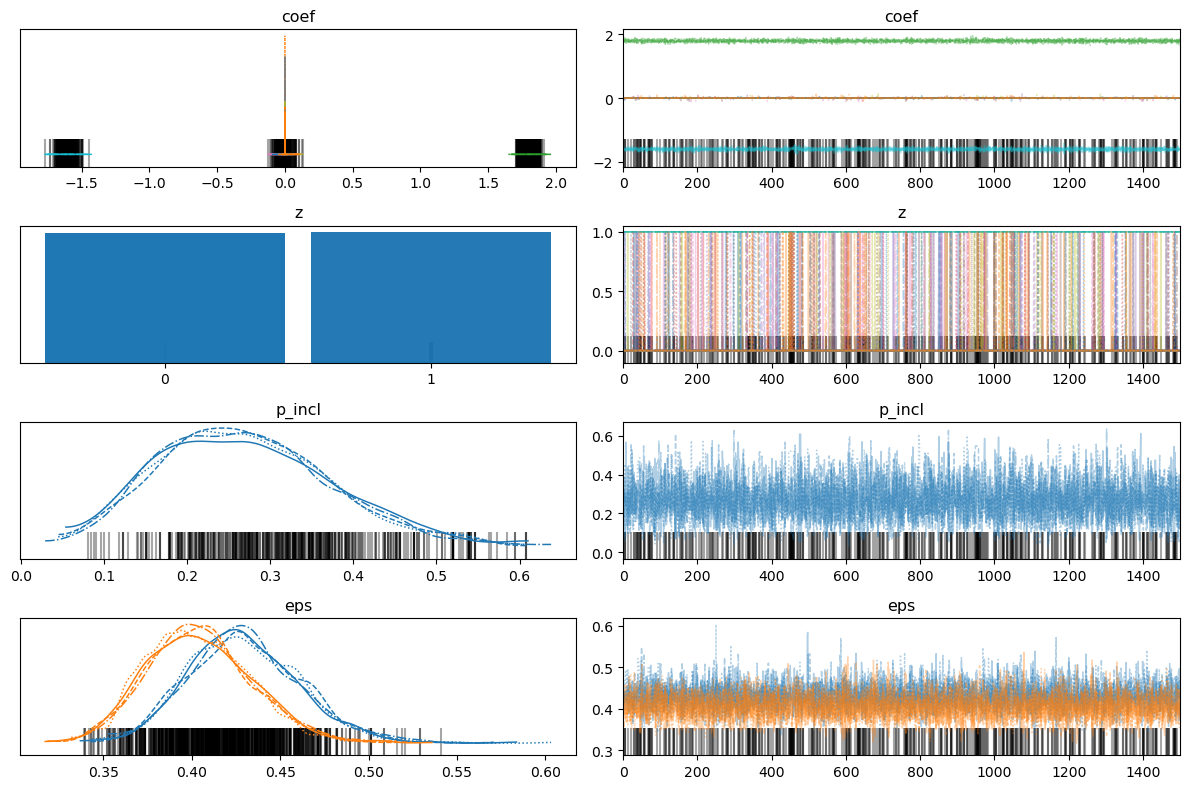

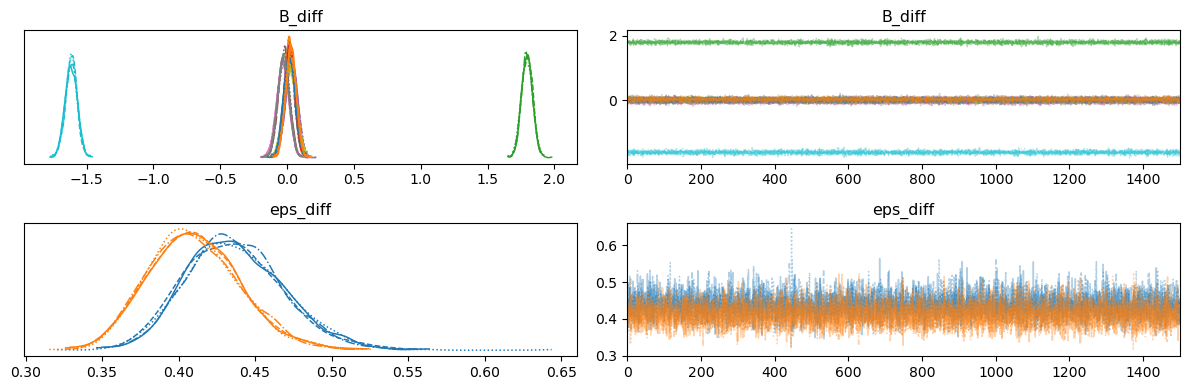

In [6]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# 1. Generate synthetic data
np.random.seed(150)
n, p, m = 100, 6, 2
X_data = np.random.normal(0, 1, size=(n, p))

# True sparse coefficients
true_B = np.zeros((p, m))
true_B[1, 0] = 1.8
true_B[4, 1] = -1.6
Y_data = X_data @ true_B + np.random.normal(0, 0.4, size=(n, m))

# 2. Spike-and-Slab model
with pm.Model() as model_spike_slab:
    p_incl = pm.Beta("p_incl", alpha=2.5, beta=2.5)
    z = pm.Bernoulli("z", p=p_incl, shape=(p, m))
    coef_slab = pm.Normal("coef_slab", mu=0.0, sigma=2.5, shape=(p, m))
    coef = pm.Deterministic("coef", z * coef_slab)
    eps = pm.HalfNormal("eps", sigma=1.0, shape=m)
    mu = pm.math.dot(X_data, coef)
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=eps, observed=Y_data)
    trace_spike_slab = pm.sample(1500, tune=500, target_accept=0.9, random_seed=123)

# 3. Diffuse Normal model
with pm.Model() as model_diffuse:
    B_diff = pm.Normal("B_diff", mu=0, sigma=50, shape=(p, m))
    eps_diff = pm.HalfNormal("eps_diff", sigma=1.0, shape=m)
    mu_diff = pm.math.dot(X_data, B_diff)
    Y_obs_diff = pm.Normal("Y_obs_diff", mu=mu_diff, sigma=eps_diff, observed=Y_data)
    trace_diffuse = pm.sample(1500, tune=500, target_accept=0.9, random_seed=123)

# 4. Trace plots
az.plot_trace(trace_spike_slab, var_names=["coef", "z", "p_incl", "eps"], compact=True)
plt.tight_layout()
plt.show()

az.plot_trace(trace_diffuse, var_names=["B_diff", "eps_diff"], compact=True)
plt.tight_layout()
plt.show()


Sequential sampling (2 chains in 1 job)
CompoundStep
>BinaryGibbsMetropolis: [indicator]
>NUTS: [coef_slab, sigma_ss]
Sampling 2 chains for 300 tune and 1_000 draw iterations (600 + 2_000 draws total) took 18 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [tau, lam, beta_hs, sigma_hs]
Sampling 2 chains for 300 tune and 1_000 draw iterations (600 + 2_000 draws total) took 14 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


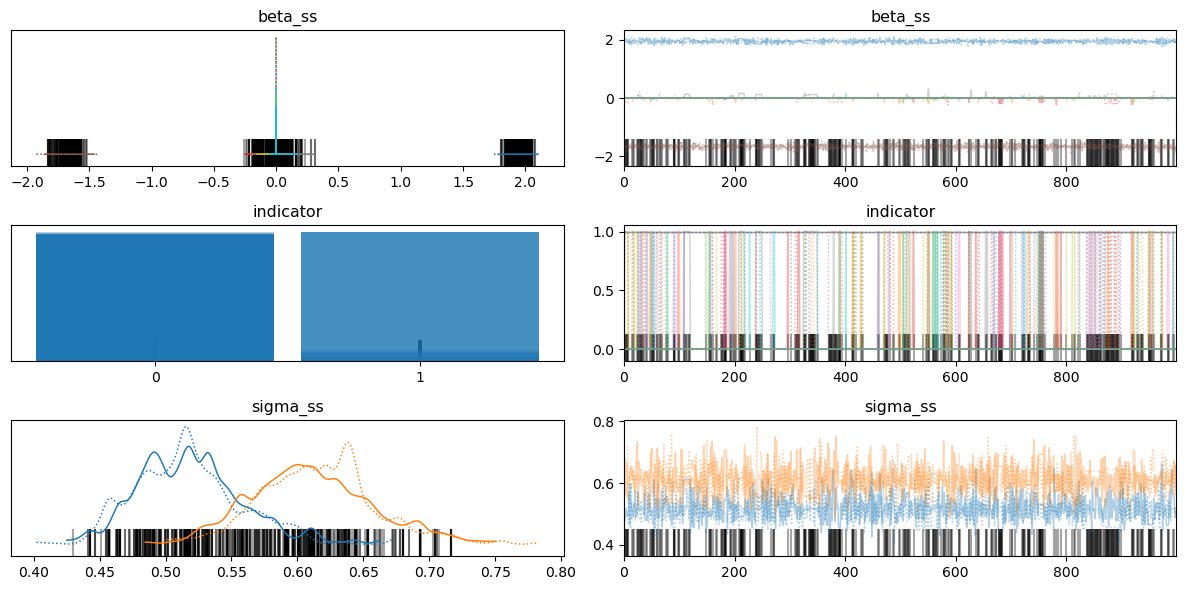

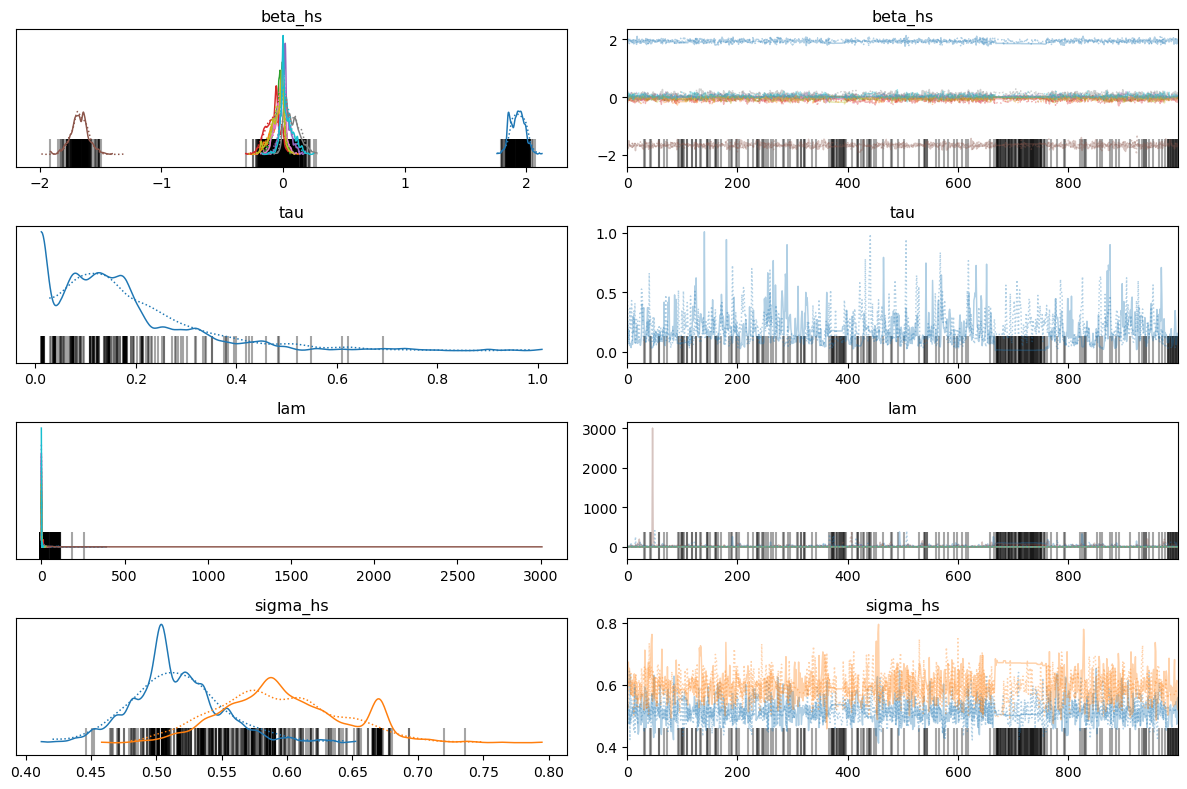

In [8]:
#Q3
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# 1. Generate Synthetic Data for Multivariate Regression
np.random.seed(2025)
n_obs = 90      
n_features = 5  
n_out = 2       

X = np.random.randn(n_obs, n_features)

# True coefficients (n_features x n_out), sparse: only a few nonzero entries
true_coef = np.zeros((n_features, n_out))
true_coef[0, 0] =  1.8    # Predictor 1 influences output 1
true_coef[2, 1] = -1.6    # Predictor 3 influences output 2

# Generate responses: Y = X * true_coef + noise
noise_level = 0.6
Y = X @ true_coef + np.random.normal(0, noise_level, (n_obs, n_out))


# 2. Spike-and-Slab Model for Variable Selection
#    - Introduces binary indicators to switch coefficients on/off.
with pm.Model() as spike_slab_model:
    indicator = pm.Bernoulli("indicator", p=0.5, shape=(n_features, n_out))
    coef_slab = pm.Normal("coef_slab", mu=0.0, sigma=5.0, shape=(n_features, n_out))
    beta_ss = pm.Deterministic("beta_ss", indicator * coef_slab)
    sigma_ss = pm.HalfNormal("sigma_ss", sigma=1.0, shape=n_out)
    mu_ss = pm.math.dot(X, beta_ss)
    Y_obs_ss = pm.Normal("Y_obs_ss", mu=mu_ss, sigma=sigma_ss, observed=Y)
    trace_ss = pm.sample(1000, tune=300, cores=1, random_seed=2024, progressbar=False)

# 3. Horseshoe Prior Model for Sparsity
with pm.Model() as horseshoe_model:
    tau = pm.HalfCauchy("tau", beta=1.0)
    lam = pm.HalfCauchy("lam", beta=1.0, shape=(n_features, n_out))
    beta_hs = pm.Normal("beta_hs", mu=0.0, sigma=tau * lam, shape=(n_features, n_out))
    sigma_hs = pm.HalfNormal("sigma_hs", sigma=1.0, shape=n_out)
    mu_hs = pm.math.dot(X, beta_hs)
    Y_obs_hs = pm.Normal("Y_obs_hs", mu=mu_hs, sigma=sigma_hs, observed=Y)
    trace_hs = pm.sample(1000, tune=300, cores=1, random_seed=2024, progressbar=False)

# 4. Compare Results: Trace Plots for Both Models
# Plot for Spike-and-Slab model
az.plot_trace(trace_ss, var_names=["beta_ss", "indicator", "sigma_ss"], compact=True)
plt.tight_layout()
plt.show()

# Plot for Horseshoe model
az.plot_trace(trace_hs, var_names=["beta_hs", "tau", "lam", "sigma_hs"], compact=True)
plt.tight_layout()
plt.show()


This code simulates a multivariate regression scenario with two response variables and a controlled sparse coefficient structure. It aims to compare how different prior assumptions affect variable selection and uncertainty estimation. A Spike-and-Slab prior introduces binary latent indicators to explicitly control inclusion of each predictor, while a diffuse Gaussian prior assumes all predictors are potentially relevant without enforcing sparsity. The models are fit using PyMC, and posterior samples are analyzed using ArviZ. In addition to estimating the regression weights, the framework helps assess the strength and stability of variable inclusion through posterior traces, allowing us to evaluate how well each approach identifies true signals under noise.